# Multi-materials simulation

In this demo, we will perform a multi-materials simulation. This will be our problem case.
The following FESTIM features will be used:
- Multi-materials
- Meshing:
    - mesh from vertices
- Boundary conditions:
    - Recombination flux
- Exports:
    - txt exports
    - Flux computations
    - Integrations over volumes for inventories calculation
- Plotting with matplotlib

## 1. Problem definition
The domain is a composite slab W/Cu/W as described below:
 <p align="center">
  <img src="https://user-images.githubusercontent.com/40028739/104934903-e10d7500-59aa-11eb-9296-17de99140701.jpg" width="40%">
</p>

- $\Omega = [0;1.5\times10^{-7}]$
- $\Omega_1 = [0;5\times10^{-8}]$ (W left)
- $\Omega_2 = [5\times10^{-8};1\times10^{-7}] $ (Cu)
- $\Omega_3 = [1\times10^{-7};1.5\times10^{-7}]$ (W right)
- $D(T) = \begin{cases}
    4.1\times 10^{-7} \exp{(-0.39/k_B T)}, & \text{on } \Omega_1 \text{ and } \Omega_3\\
    1.5\times 10^{-7} \exp{(-0.15/k_B T)}, & \text{on } \Omega_2
    \end{cases}$
- Trap 1 in $\Omega_2$ and $\Omega_3$:
    - Density: $n_1 = 1.3\times 10^{-3} \text{ at.fr.}$
    - Trapping rate: $k(T) = 3.8 \times 10^{-17} \exp{(-0.39/k_B T)} \text{ s}^{-1}$
    - Detrapping rate: $p(T) = 8.4\times 10^{12} \exp{(-1.2/k_B T)} \text{ s}^{-1}$
- Trap 2 in $\Omega_2$:
    - Density: $n_2 = 5\times10^{-5} \text{ at.fr.}$
    - Trapping rate: $k(T) = 6 \times 10^{-17} \exp{(-0.39/k_B T)} \text{ s}^{-1}$
    - Detrapping rate: $p(T) = 8\times10^{13} \exp{(-1.0/k_B T)} \text{ s}^{-1}$


A Dirichlet boundary conditions will be imposed on $\Gamma_\mathrm{left}$ and a recombination flux is imposed on $\Gamma_\mathrm{right}$.

- $c_\mathrm{m} = 10^{20} \; \mathrm{m}^{-3} \quad \text{on } \Gamma_\mathrm{left}$
- $-D \nabla c_\mathrm{m} \cdot n = -K c_\mathrm{m}^2 \quad \text{on }\Gamma_\mathrm{right}$
with $K = 2.9\times 10^{-14} \exp{(-1.92/k_B T)} \; \mathrm{m}^4 \mathrm{s}^{-1}$

## 2. Implementation
The first step is to create a FESTIM Simulation object

In [1]:
import festim as F

my_model = F.Simulation()

In [2]:
tungsten_left = F.Material(
    id=1,
    D_0=4.1e-7,
    E_D=0.39,
    S_0=1.87e24,
    E_S=1.04,
    borders=[0, 0.5e-7]
    )

copper = F.Material(
    id=2,
    D_0=1.5e-7,
    E_D=0.15,
    S_0=3.14e24,
    E_S=0.57,
    borders=[0.5e-7, 1e-7]
    )

tungsten_right = F.Material(
    id=3,
    D_0=4.1e-7,
    E_D=0.39,
    S_0=1.87e24,
    E_S=1.04,
    borders=[1e-7, 1.5e-7]
    )

my_model.materials = [tungsten_left, copper, tungsten_right]

In [3]:
import numpy as np

vertices = np.concatenate(
        [np.linspace(0, 0.5e-7, num=200),
        np.linspace(0.5e-7, 1e-7, num=100),
        np.linspace(1e-7, 1.5e-7, num=200)])

my_model.mesh = F.MeshFromVertices(vertices)

In [4]:
tungsten_density = 6.3e28

trap_tungsten = F.Trap(
    k_0=3.8e-17,
    E_k=0.39,
    p_0=8.4e12,
    E_p=1.2,
    density=1.3e-3*tungsten_density,
    materials=[tungsten_left, tungsten_right]
)

copper_density = 8.43e28

trap_copper = F.Trap(
    k_0=6e-17,
    E_k=0.39,
    p_0=8e13,
    E_p=0.9,
    density=5e-5*copper_density,
    materials=[copper]
)

my_model.traps = F.Traps([trap_tungsten, trap_copper])

In [5]:
my_model.T = F.Temperature(320)

In [6]:
left_bc = F.DirichletBC(
    surfaces=1,
    value=1e20
    )

right_bc = F.RecombinationFlux(
    surfaces=2,
    Kr_0=2.9e-10,
    E_Kr=1,
    order=2
    )

my_model.boundary_conditions = [left_bc, right_bc]

In [7]:
folder = 'outputs'

derived_quantities = F.DerivedQuantities(filename="{}/derived_quantities.csv".format(folder))
derived_quantities.derived_quantities = [
    F.TotalVolume(field="retention", volume=1),
    F.TotalVolume(field="retention", volume=2),
    F.TotalVolume(field="retention", volume=3),
    F.TotalVolume(field="1", volume=1),
    F.TotalVolume(field="1", volume=3),
    F.TotalVolume(field="2", volume=2),
    F.SurfaceFlux(field="solute", surface=1),
    F.SurfaceFlux(field="solute", surface=2),
]

txt_exports = F.TXTExports(
    fields=['1', '2', 'solute', 'retention'],
    labels=['trap1', 'trap2', 'mobile', 'retention'],
    times=[2000, 17000, 20000],
    folder=folder
    )

my_model.exports = [derived_quantities] + txt_exports.exports

In [8]:
my_model.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-09,
    final_time=2e4,
    chemical_pot=False,
    traps_element_type="DG",
    maximum_iterations=50
)


my_model.dt = F.Stepsize(
    initial_value=50,
    stepsize_change_ratio=1.1,
    dt_min=1e-5)

In [9]:
my_model.initialise()
my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        2.0e+04 s    Ellapsed time so far: 2.6 s


Text(0.5, 0, 'Time (s)')

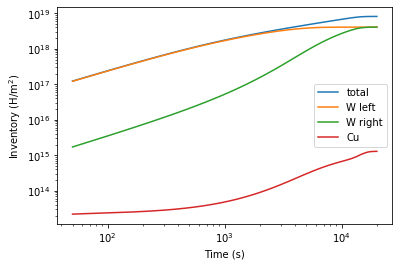

In [18]:
import matplotlib.pyplot as plt

t = derived_quantities.t
ret_cu = derived_quantities.filter(volumes=copper.id, fields="retention").data
ret_w_left = derived_quantities.filter(volumes=tungsten_left.id, fields="retention").data
ret_w_right = derived_quantities.filter(volumes=tungsten_right.id, fields="retention").data

total = np.sum([ret_cu, ret_w_left, ret_w_right], axis=0)

plt.figure()
plt.plot(t, total, label="total")
plt.plot(t, ret_w_left, label="W left")
plt.plot(t, ret_w_right, label="W right")
plt.plot(t, ret_cu, label="Cu")

plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.ylabel("Inventory (H/m$^2$)")
plt.xlabel("Time (s)")

Text(0, 0.5, 'solute concentration (H/m$^3$)')

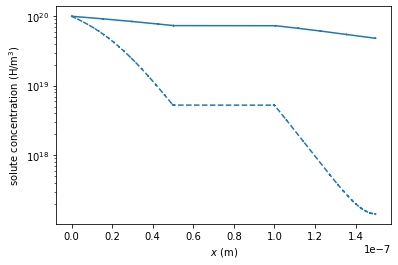

In [19]:
mobile_1 = np.genfromtxt(folder + '/mobile_2000.0s.txt')
mobile_2 = np.genfromtxt(folder + '/mobile_17000.0s.txt')

plt.figure()
plt.plot(mobile_1[:, 0], mobile_1[:, 1], linestyle="--")
plt.plot(mobile_2[:, 0], mobile_2[:, 1], color="tab:blue")
plt.yscale("log")
plt.xlabel("$x$ (m)")
plt.ylabel("solute concentration (H/m$^3$)")

In [20]:
# tolerance is increased for better convergence

my_model.settings.absolute_tolerance = 1e12
my_model.settings.chemical_pot = True

my_model.initialise()
my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        2.0e+04 s    Ellapsed time so far: 5.7 s


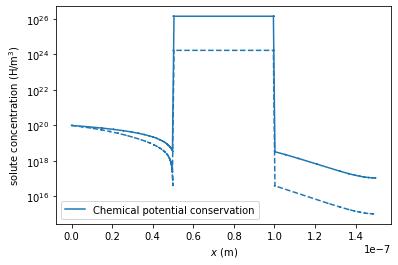

In [21]:
solute_1_chemical_potential = np.genfromtxt(folder + '/mobile_2000.0s.txt')
solute_2_chemical_potential = np.genfromtxt(folder + '/mobile_17000.0s.txt')

plt.figure()
plt.plot(solute_1_chemical_potential[:, 0], solute_1_chemical_potential[:, 1], linestyle="--")
plt.plot(solute_2_chemical_potential[:, 0], solute_2_chemical_potential[:, 1],
         color="tab:blue", label="Chemical potential conservation")

plt.yscale("log")
plt.xlabel("$x$ (m)")
plt.ylabel("solute concentration (H/m$^3$)")
plt.legend()